In [1]:
# Imports 
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, time, copy

In [2]:
data_dir = 'ArASL_Database_54K_Final'

In [3]:
# TODO: Define your transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in ['train', 'val']}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

# dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}


class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

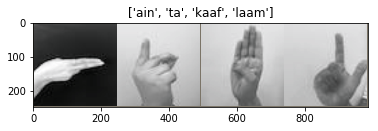

torch.Size([32, 3, 244, 244]) torch.Size([32])


In [4]:
def imshow(inp, title=None):
    """Imshow for vectors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
# get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

letters = [class_names[i] for i in classes]
# make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=letters[:4])
print(inputs.shape, classes.shape)

In [5]:
print("Number of classes:", len(class_names))

Number of classes: 32


In [6]:
# TODO: Build and train your network

# Load the pretrianed model
model = models.vgg16(pretrained=True) 

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add new classifier
model.classifier[6] = nn.Sequential(
                        nn.Linear(in_features=4096, out_features=256),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(in_features=256, out_features=32),
                        nn.LogSoftmax(dim=1)
                    )

In [7]:
# send the model to gpu
model.to(device);

In [8]:
# Total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters')

# Total trainable parameters
total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable:,} training parameters')

135,317,600 total parameters
1,057,056 training parameters


In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [10]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([32, 256])
torch.Size([32])


In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                ## Save the model locally
                torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict()}, "ArASL_Database_54K_Final/model/checkpoint.pth.tar")

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.9219 Acc: 0.4633
val Loss: 1.1350 Acc: 0.6753

Epoch 1/24
----------
train Loss: 1.0960 Acc: 0.6589
val Loss: 0.9045 Acc: 0.7226

Epoch 2/24
----------
train Loss: 0.9189 Acc: 0.7060
val Loss: 0.7949 Acc: 0.7487

Epoch 3/24
----------
train Loss: 0.8110 Acc: 0.7402
val Loss: 0.7269 Acc: 0.7708

Epoch 4/24
----------
train Loss: 0.7504 Acc: 0.7585
val Loss: 0.6837 Acc: 0.7840

Epoch 5/24
----------
train Loss: 0.6951 Acc: 0.7756
val Loss: 0.6568 Acc: 0.7915

Epoch 6/24
----------
train Loss: 0.6531 Acc: 0.7874
val Loss: 0.6201 Acc: 0.7996

Epoch 7/24
----------
train Loss: 0.6202 Acc: 0.8021
val Loss: 0.6042 Acc: 0.8042

Epoch 8/24
----------
train Loss: 0.6034 Acc: 0.8064
val Loss: 0.6020 Acc: 0.8004

Epoch 9/24
----------
train Loss: 0.5957 Acc: 0.8130
val Loss: 0.5989 Acc: 0.8039

Epoch 10/24
----------
train Loss: 0.5891 Acc: 0.8149
val Loss: 0.5927 Acc: 0.8078

Epoch 11/24
----------
train Loss: 0.5913 Acc: 0.8100
val Loss: 0.5919 Acc: 0.8072

Ep

In [11]:
    def reLoadCheckpoint(model, optimizer, path, train=True):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        if train == False:
            model.eval()
        else:
            model.train()
        return model

model = reLoadCheckpoint(model, optimizer, 'ArASL_Database_54K_Final/model/checkpoint.pth.tar', train=False)

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

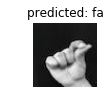

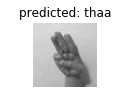

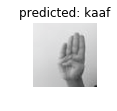

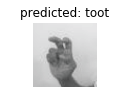

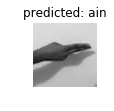

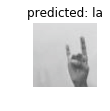

In [13]:
visualize_model(model)

In [24]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    return img

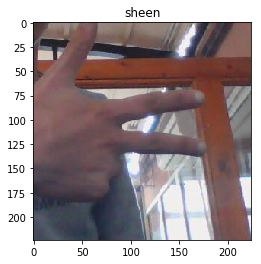

In [25]:
with torch.no_grad():
  model.eval()
  image = process_image('/home/kelwa/Desktop/2019-03-17-095855.jpg')
  temp = image.copy()
  temp = torch.Tensor(temp)
  image = torch.Tensor(image)
  image = image.view(1, 3, 224, 224)
  out = model(image.cuda())
  _, ps = torch.max(out,1)    
  imshow(temp, title=class_names[ps])

In [28]:
device = torch.device("cpu")

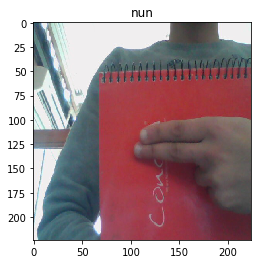

In [29]:
with torch.no_grad():
  model.eval()
  image = process_image('/home/kelwa/Desktop/AIN.jpg')
  temp = image.copy()
  temp = torch.Tensor(temp)
  image = torch.Tensor(image)
  image = image.view(1, 3, 224, 224)
  out = model(image.cuda())
  _, ps = torch.max(out,1)
  imshow(temp, title=class_names[ps])